In [1]:
%matplotlib inline 
import climlab

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [26]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8 

In [38]:
# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T,P):
    return np.divide(params.R_a, params.cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [75]:
def calc_olr(SST, CO2ppmv, nlev=30):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=nlev, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params.RH)

    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, 
                                  albedo=0.3, ozone_file=None, 
                                  return_spectral_olr=True, icld=0,
                                  absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                  'CH4':0.,
                                                  'N2O':0.,
                                                  'O2':0.,
                                                  'CFC11':0.,
                                                  'CFC12':0.,
                                                  'CFC22':0.,
                                                  'CCL4':0.,
                                                  'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    return olr, rad.OLR_sr

In [76]:
OLR0, OLR0_sr = calc_olr(SST=288,CO2ppmv=0)
OLR0

Field([285.86471618])

In [46]:
central_rrtmg_lw_bands = np.array([180,425,565,665,760,900,
                                   1030,1130,1285,1435,1640,
                                   1940,2165,2315,2490,2925])

nu_lower_rrtmg = np.array([10., 350., 500., 630., 700., 820., 980., 1080., 1180., 1390., 1480., 1800., 2080., 2250., 2380., 2600.])
nu_upper_rrtmg = np.array([350., 500., 630., 700., 820., 980., 1080., 1180., 1390., 1480., 1800., 2080., 2250., 2380., 2600., 3250.])

In [77]:
%%time

TEMPS = np.arange(280, 326)

lambda_rrtm_0ppm = xr.DataArray(np.zeros((len(TEMPS),len(central_rrtmg_lw_bands))), dims=['Ts', 'band'], 
                                coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'}),
                                        'band':central_rrtmg_lw_bands},
                                attrs={'standard_name': 'lambda', 'units': 'W/m2'})


for idx,sst in enumerate(TEMPS):

    olr, olr_sr = calc_olr(SST=sst,CO2ppmv=0)

    olrp1, olr_srp1 = calc_olr(SST=sst+1,CO2ppmv=0)
    
    lambda_rrtm_0ppm.loc[dict(Ts=sst)] = (olr_srp1 - olr_sr)[0,:]


CPU times: user 3.25 s, sys: 106 ms, total: 3.36 s
Wall time: 3.36 s


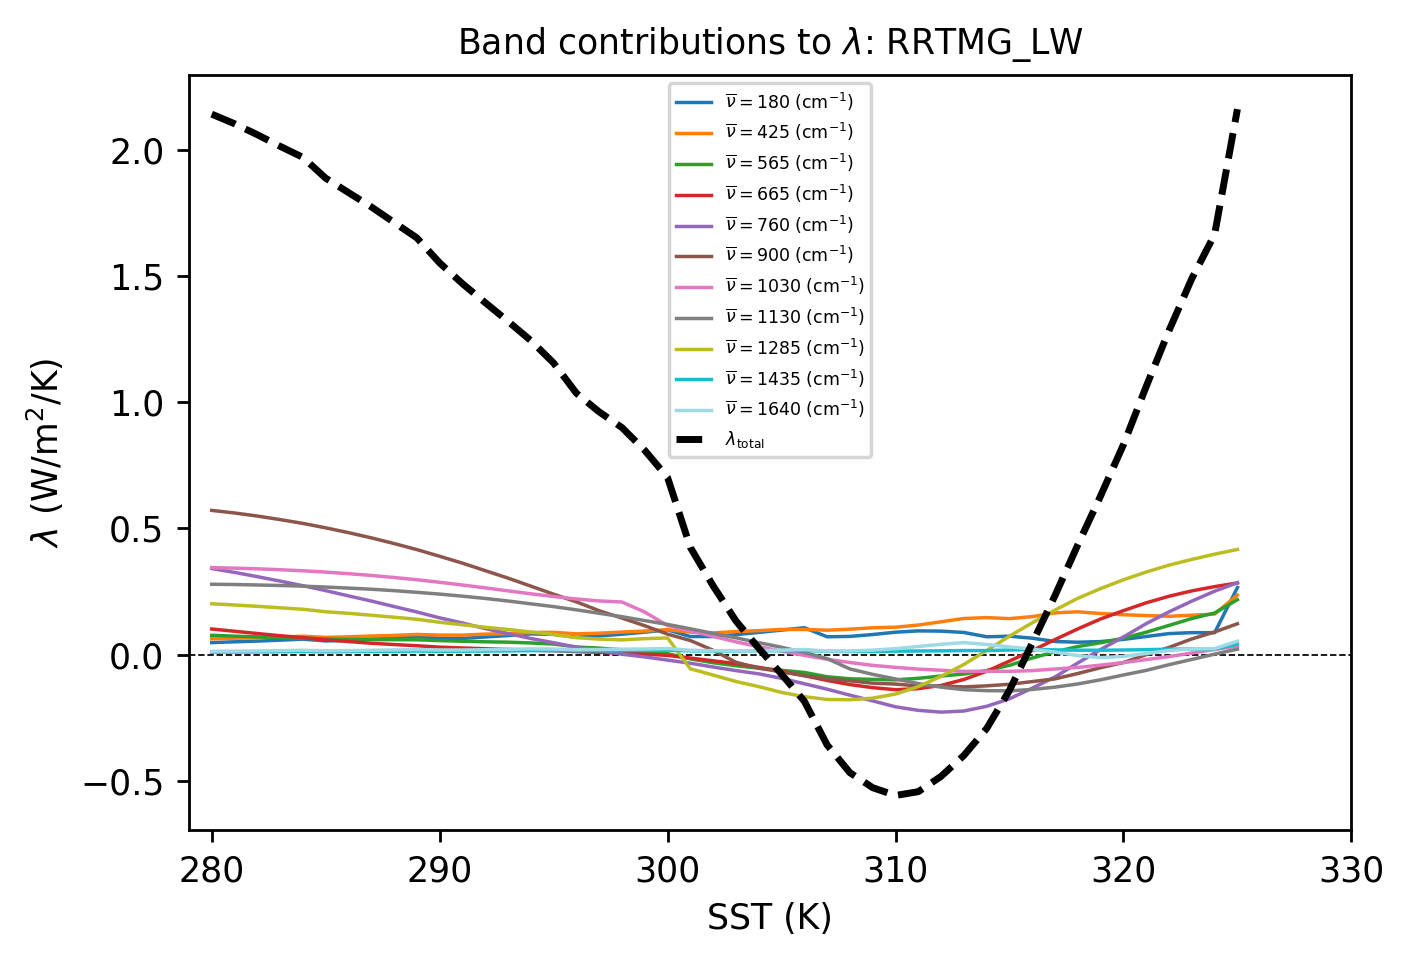

In [78]:
fig, ax = plt.subplots(dpi=250, figsize=(6,4))

n=len(central_rrtmg_lw_bands[:11])
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

for i in range(n):
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)"   # + fr"$\Delta\nu=${delwave[i]} (cm$^{{-1}}$)" #+ "\n" +
    ax.plot(TEMPS, lambda_rrtm_0ppm[:,i], color=colors[i], label=string, lw=1)

_ = (lambda_rrtm_0ppm.sum('band')).plot(ax=ax, color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$')

ax.set_xlabel(r"SST (K)")
ax.set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")

ax.set_title(r"Band contributions to $\lambda$: RRTMG_LW", fontsize=10)

ax.hlines(y=0, xmin=279, xmax=330, linestyle='--', color='k', lw=0.5)
ax.set_xlim(279, 330)
ax.legend(loc='best', prop={'size': 5})

#plt.savefig("./Figs/lambda_band_contributions_with_total.png", dpi=400, facecolor='white', bbox_inches='tight')

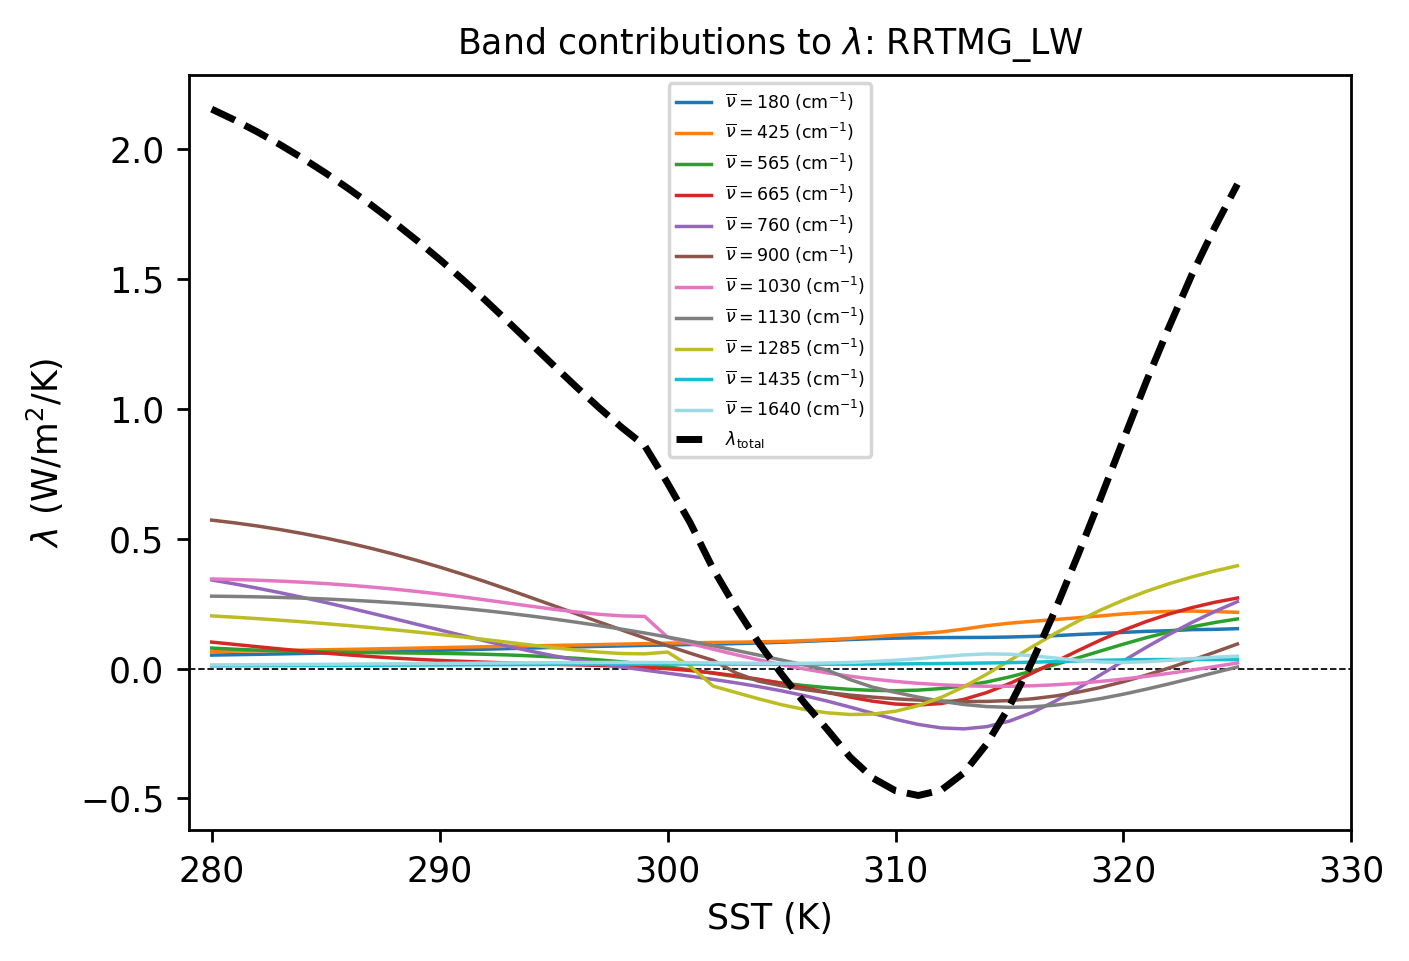

In [73]:
fig, ax = plt.subplots(dpi=250, figsize=(6,4))

n=len(central_rrtmg_lw_bands[:11])
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

for i in range(n):
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)"   # + fr"$\Delta\nu=${delwave[i]} (cm$^{{-1}}$)" #+ "\n" +
    ax.plot(TEMPS, lambda_rrtm_0ppm[:,i], color=colors[i], label=string, lw=1)

_ = (lambda_rrtm_0ppm.sum('band')).plot(ax=ax, color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$')

ax.set_xlabel(r"SST (K)")
ax.set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")

ax.set_title(r"Band contributions to $\lambda$: RRTMG_LW", fontsize=10)

ax.hlines(y=0, xmin=279, xmax=330, linestyle='--', color='k', lw=0.5)
ax.set_xlim(279, 330)
ax.legend(loc='best', prop={'size': 5})

#plt.savefig("./Figs/lambda_band_contributions_with_total.png", dpi=400, facecolor='white', bbox_inches='tight')

In [44]:
lambdanu_0ppm = np.load("../Data/lambdanu_0ppm.pickle", allow_pickle=True)['lambdanu']

In [45]:
rfm_lambdanu_0ppm = xr.DataArray(dims=['Ts', 'wavenumber'], coords={'Ts': np.arange(280, 326), 'wavenumber': lambdanu_0ppm['nu']})

for ts in np.arange(280, 326):
    rfm_lambdanu_0ppm.loc[dict(Ts=ts)] = lambdanu_0ppm[ts]['lambda']

In [47]:
rfm_lambda_bands_0ppm = xr.DataArray(dims=['Ts', 'band'], coords={'Ts': np.arange(280, 326), 'band':central_rrtmg_lw_bands})

for ts in np.arange(280, 326):
    for idx, nuband in enumerate(central_rrtmg_lw_bands):
        rfm_lambda_bands_0ppm.loc[dict(Ts=ts, band=nuband)] = rfm_lambdanu_0ppm.loc[dict(Ts=ts)].sel(wavenumber=slice(nu_lower_rrtmg[idx], nu_upper_rrtmg[idx])).integrate('wavenumber')

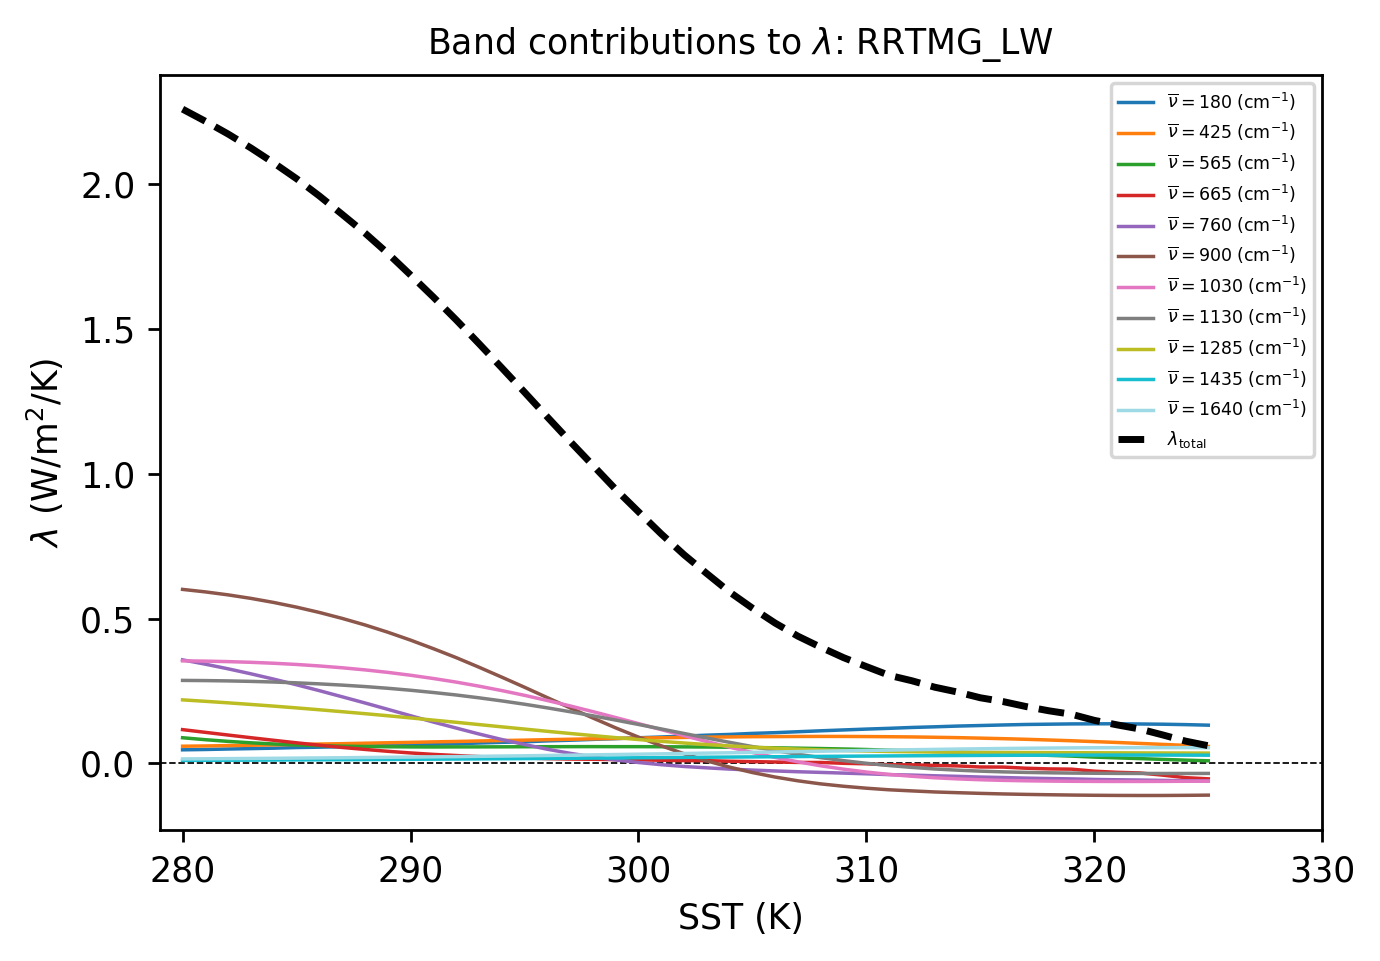

In [49]:
fig, ax = plt.subplots(dpi=250, figsize=(6,4))

n=len(central_rrtmg_lw_bands[:11])
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

for i in range(n):
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)"   # + fr"$\Delta\nu=${delwave[i]} (cm$^{{-1}}$)" #+ "\n" +
    ax.plot(np.arange(280, 326), rfm_lambda_bands_0ppm[:,i], color=colors[i], label=string, lw=1)

_ = (rfm_lambda_bands_0ppm.sum('band')).plot(ax=ax, color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$')

ax.set_xlabel(r"SST (K)")
ax.set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")

ax.set_title(r"Band contributions to $\lambda$: RRTMG_LW", fontsize=10)

ax.hlines(y=0, xmin=279, xmax=330, linestyle='--', color='k', lw=0.5)
ax.set_xlim(279, 330)
ax.legend(loc='best', prop={'size': 5})

#plt.savefig("./Figs/lambda_band_contributions_with_total.png", dpi=400, facecolor='white', bbox_inches='tight')

# Compare RRTMG and RFM - 0ppm

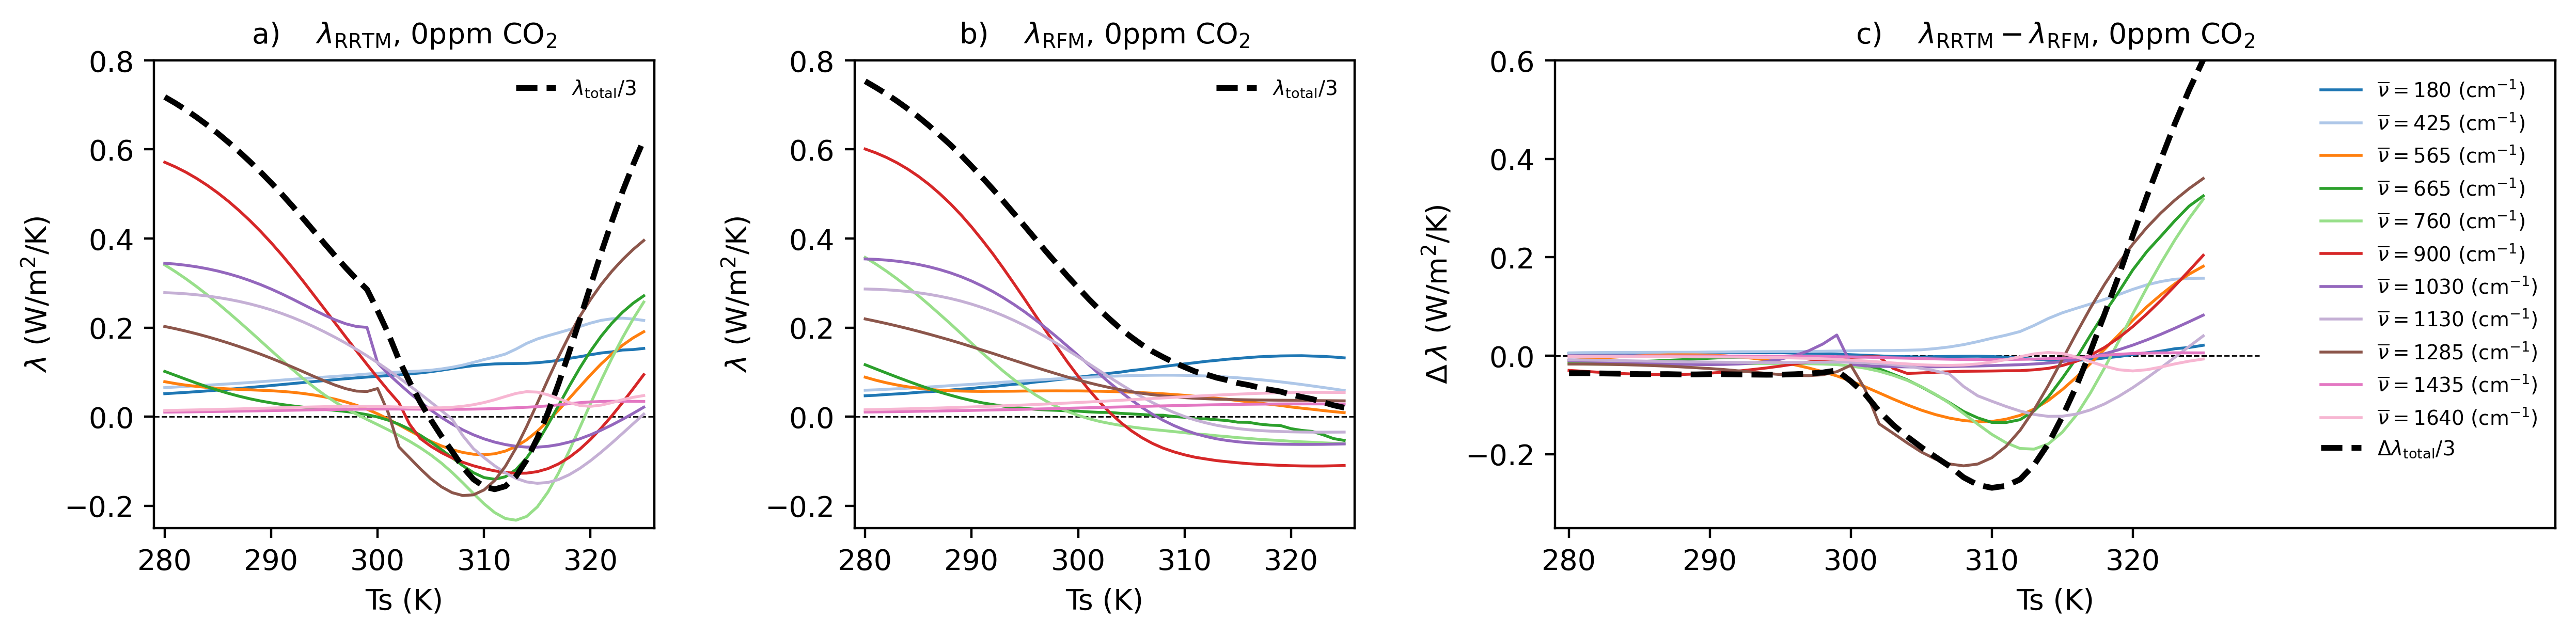

In [74]:
fig, axs = plt.subplots(ncols=3, dpi=400, figsize=(15,3), gridspec_kw={'width_ratios':[1,1,2]})

n=len(central_rrtmg_lw_bands)
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

""" RRTMG """
for i in range(n)[:11]:  
    axs[0].plot(np.arange(280, 326), lambda_rrtm_0ppm[:,i], color=colors[i], lw=1)

l1 = (lambda_rrtm_0ppm.sum('band')/3).plot(ax=axs[0], color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$/3')
axs[0].legend(frameon=False, prop={'size': 7})

""" RFM """

for i in range(n)[:11]:
    axs[1].plot(np.arange(280, 326), rfm_lambda_bands_0ppm[:,i], color=colors[i], lw=1)

l2 = (rfm_lambda_bands_0ppm.sum('band')/3).plot(ax=axs[1], color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$/3')
axs[1].legend(frameon=False, prop={'size': 7})

""" RRTMG-RFM """
for i in range(n)[:11]:
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)" 
    axs[2].plot(np.arange(280, 326), lambda_rrtm_0ppm[:,i]-rfm_lambda_bands_0ppm[:,i], color=colors[i], label=string, lw=1)

_ = ((lambda_rrtm_0ppm.sum('band')-rfm_lambda_bands_0ppm.sum('band'))/3).plot(ax=axs[2], color='black', lw=2, 
                                                                              linestyle='--', 
                                                                              label=r'$\Delta\lambda_{\mathrm{total}}$/3')


axs[2].set_xlabel(r"SST (K)")

axs[0].set_title(r"a)    $\lambda_{\mathrm{RRTM}}$, 0ppm CO$_{2}$", fontsize=10)
axs[1].set_title(r"b)    $\lambda_{\mathrm{RFM}}$, 0ppm CO$_{2}$", fontsize=10)
axs[2].set_title(r"c)    $\lambda_{\mathrm{RRTM}}-\lambda_{\mathrm{RFM}}$, 0ppm CO$_{2}$", fontsize=10)

for ax in axs:
    ax.hlines(y=0, xmin=279, xmax=326, linestyle='--', color='k', lw=0.5)
    ax.set_xlim(279, 326)
    ax.set_xlabel("Ts (K)")
    ax.set_ylim(-0.25, 0.8)
    
axs[0].set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")
axs[1].set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")
axs[2].set_ylabel(r"$\Delta \, \lambda$ (W/m$^{2}$/K)")

axs[2].hlines(y=0, xmin=279, xmax=329, linestyle='--', color='k', lw=0.5)
axs[2].set_xlim(279, 350)
axs[2].legend(loc='upper right', frameon=False, prop={'size': 7})
axs[2].set_ylim(-0.35, 0.6)

axs[2].set_xticks([280, 290, 300, 310, 320])

fig.subplots_adjust(wspace=0.3)
#plt.savefig("../Figs/lambda_band_RRTM_vs_RFM_0ppm.png", dpi=400, facecolor='white', bbox_inches='tight')